# redux 

In [1]:
%matplotlib inline
path = "data/redux/"
import utils; reload(utils)
from utils import *

Using Theano backend.
Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


In [2]:
batch_size=64

In [39]:
%mv ../data .

# Create Validation Set and Sample

done

# Move to separate dirs for each set


done

#  Finetune and Train

In [3]:
from vgg16 import Vgg16

In [4]:
vgg = Vgg16()

In [5]:
batches = vgg.get_batches(path+'train', batch_size=batch_size)
val_batches = vgg.get_batches(path+'valid', batch_size=batch_size*2)
vgg.finetune(batches)

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


### epoch 1

In [22]:
vgg.fit(batches, val_batches, nb_epoch=1)

Epoch 1/1
23000/23000 [==============================] - 645s - loss: 0.7998 - acc: 0.9479 - val_loss: 0.3748 - val_acc: 0.9765


In [23]:
vgg.model.save_weights(path+'results/ft1.h5')

### epoch 2

In [24]:
vgg.fit(batches, val_batches, nb_epoch=1)

Epoch 1/1
23000/23000 [==============================] - 636s - loss: 0.5294 - acc: 0.9667 - val_loss: 0.3582 - val_acc: 0.9775


In [25]:
vgg.model.save_weights(path+'results/ft2.h5')

### epoch 3 

In [26]:
vgg.model.optimizer.lr = 0.01

In [27]:
vgg.fit(batches, val_batches, nb_epoch=1)

Epoch 1/1
23000/23000 [==============================] - 639s - loss: 0.5401 - acc: 0.9659 - val_loss: 0.2821 - val_acc: 0.9825


In [28]:
vgg.model.save_weights(path+'results/ft2_1.h5')

### epoch 4!!!

In [29]:
vgg.fit(batches, val_batches, nb_epoch=1)

Epoch 1/1
23000/23000 [==============================] - 636s - loss: 0.4608 - acc: 0.9710 - val_loss: 0.2899 - val_acc: 0.9820


In [30]:
vgg.model.save_weights(path+'results/ft2_2.h5')

In [6]:
vgg.model.load_weights(path+'results/ft2_2.h5')

#### try another epoch or 2 

In [7]:
vgg.fit(batches, val_batches, nb_epoch=1)
vgg.model.save_weights(path+'results/ft2_3.h5')
vgg.fit(batches, val_batches, nb_epoch=1)
vgg.model.save_weights(path+'results/ft2_4.h5')

Epoch 1/1
23000/23000 [==============================] - 646s - loss: 0.4819 - acc: 0.9697 - val_loss: 0.3330 - val_acc: 0.9790
Epoch 1/1
23000/23000 [==============================] - 643s - loss: 0.4614 - acc: 0.9709 - val_loss: 0.1950 - val_acc: 0.9875


# Predict and Submit

In [8]:
batches, preds = vgg.test(path+'test', batch_size = batch_size*2)

Found 12500 images belonging to 1 classes.


In [9]:
filenames = batches.filenames

In [10]:
preds[:5] 

array([[ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 0.,  1.]], dtype=float32)

In [11]:
filenames[:5]

['unknown/9292.jpg',
 'unknown/12026.jpg',
 'unknown/9688.jpg',
 'unknown/4392.jpg',
 'unknown/779.jpg']

In [12]:
save_array(path+'results/test_preds+2epoch.dat', preds)
save_array(path+'results/filenames+2epoch.dat', filenames)

In [13]:
preds = load_array(path+'results/test_preds+2epoch.dat')
filenames = load_array(path+'results/filenames+2epoch.dat')

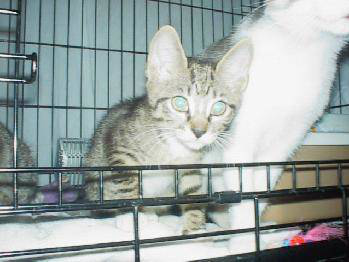

In [14]:
from PIL import Image
Image.open(path+'test/'+filenames[0])

In [15]:
isdog = preds[:,1]
isdog[:5]

array([ 0.,  0.,  0.,  0.,  1.], dtype=float32)

### fix for log loss problem

In [16]:
isdog = np.clip(preds[:,1], 0.02, 0.98)

In [17]:
ids = [int(f[8:f.find('.')]) for f in filenames]
ids[:5]

[9292, 12026, 9688, 4392, 779]

In [18]:
subm = np.stack([ids,isdog], axis=1)
subm[:5]

array([[  9.2920e+03,   2.0000e-02],
       [  1.2026e+04,   2.0000e-02],
       [  9.6880e+03,   2.0000e-02],
       [  4.3920e+03,   2.0000e-02],
       [  7.7900e+02,   9.8000e-01]])

In [19]:
np.savetxt('data/redux/brian-submission4.csv', subm, fmt='%d,%.5f', header='id,label', comments='')

In [20]:
from IPython.display import FileLink
FileLink('data/redux/brian-submission4.csv')

/home/ubuntu/deep/nbs/data/redux/brian-submission4.csv

# Visualizing results

In [22]:
vgg.model.load_weights(path+'results/ft2_4.h5')

In [23]:
val_batches, probs = vgg.test(path+'valid', batch_size = batch_size)

Found 2000 images belonging to 2 classes.


In [24]:
labels = val_batches.classes
filenames = val_batches.filenames

In [26]:
probs = probs[:,0]
preds = np.round(1-probs)
probs[:8]

array([ 1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.], dtype=float32)

In [27]:
preds[:8]

array([ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.], dtype=float32)

In [28]:
# Number of images to view for each visualization task
n_view = 4

In [29]:
def plots_idx(idx, titles=None):
    plots([image.load_img(path + 'valid/' + filenames[i]) for i in idx], titles=titles)

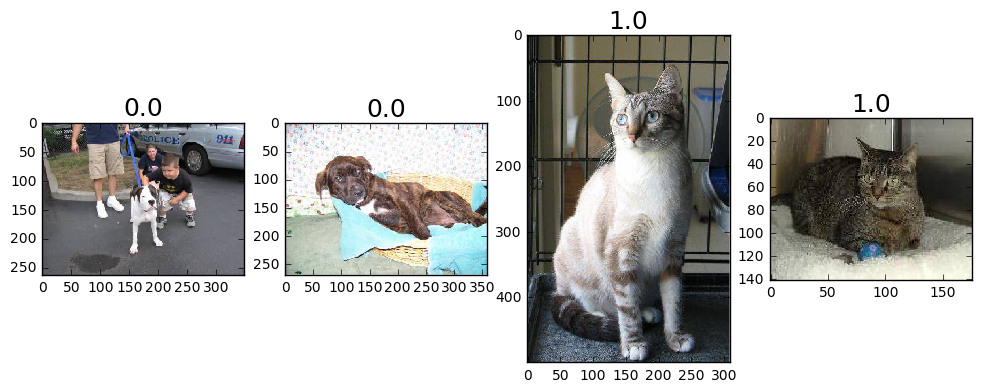

In [30]:
#1. A few correct labels at random
correct = np.where(preds==labels)[0]
idx = permutation(correct)[:n_view]
plots_idx(idx, probs[idx])

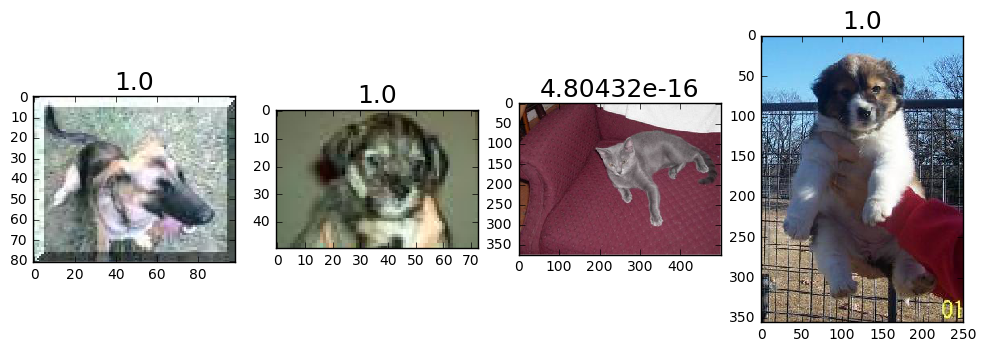

In [71]:
#2. A few incorrect labels at random
incorrect = np.where(preds!=labels)[0]
idx = permutation(incorrect)[:n_view]
plots_idx(idx, probs[idx])

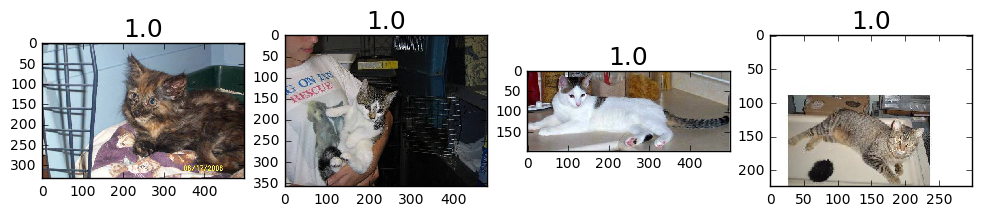

In [72]:
#3. The images we most confident were cats, and are actually cats
correct_cats = np.where((preds==0) & (preds==labels))[0]
most_correct_cats = np.argsort(probs[correct_cats])[::-1][:n_view]
plots_idx(correct_cats[most_correct_cats], probs[correct_cats][most_correct_cats])

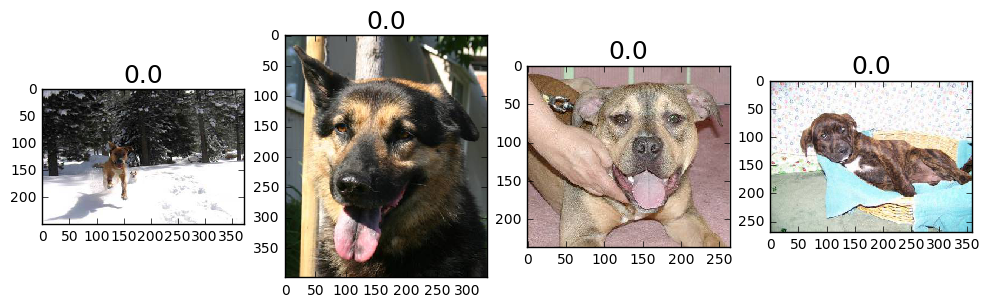

In [73]:
# as above, but dogs
correct_dogs = np.where((preds==1) & (preds==labels))[0]
most_correct_dogs = np.argsort(probs[correct_dogs])[:n_view]
plots_idx(correct_dogs[most_correct_dogs], probs[correct_dogs][most_correct_dogs])

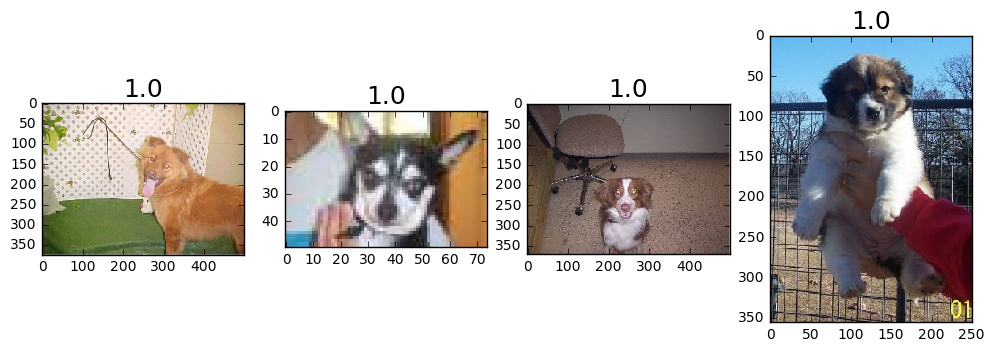

In [74]:
#3. The images we were most confident were cats, but are actually dogs
incorrect_cats = np.where((preds==0) & (preds!=labels))[0]
most_incorrect_cats = np.argsort(probs[incorrect_cats])[::-1][:n_view]
plots_idx(incorrect_cats[most_incorrect_cats], probs[incorrect_cats][most_incorrect_cats])

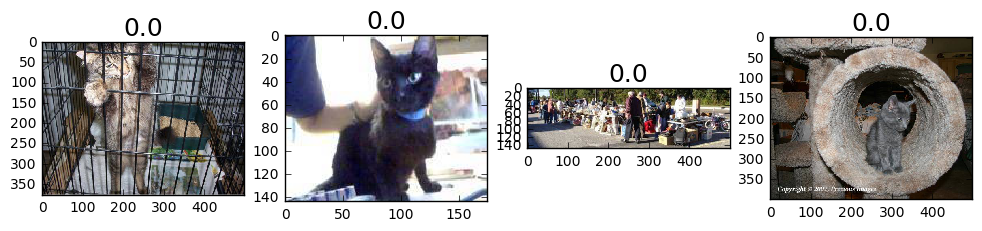

In [75]:
#3. The images we were most confident were dogs, but are actually cats
incorrect_dogs = np.where((preds==1) & (preds!=labels))[0]
most_incorrect_dogs = np.argsort(probs[incorrect_dogs])[:n_view]
plots_idx(incorrect_dogs[most_incorrect_dogs], probs[incorrect_dogs][most_incorrect_dogs])

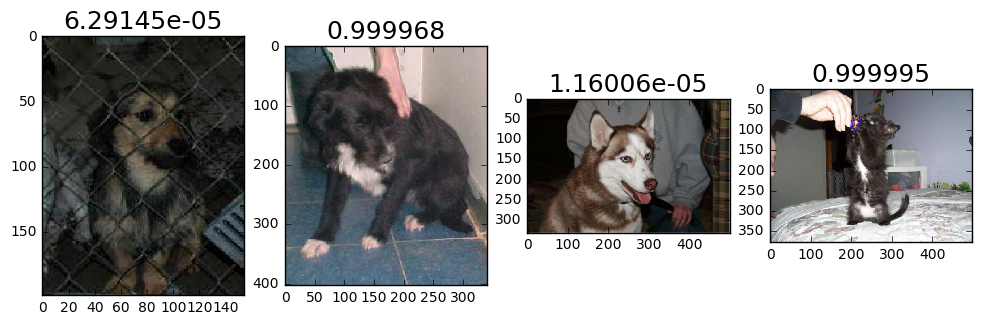

In [76]:
#5. The most uncertain labels (ie those with probability closest to 0.5).
most_uncertain = np.argsort(np.abs(probs-0.5))
plots_idx(most_uncertain[:n_view], probs[most_uncertain])

[[1007   10]
 [  16  967]]


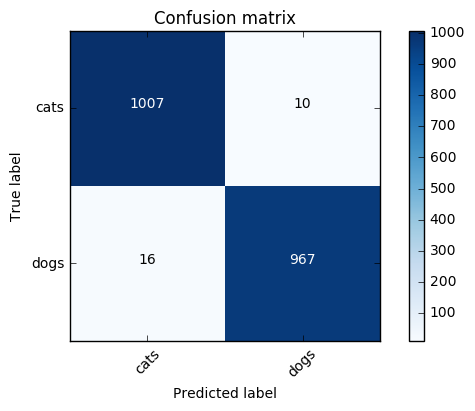

In [31]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(labels, preds)
plot_confusion_matrix(cm, val_batches.class_indices)